# Rate-Distortion Optimization II
*Also check out [Part I](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1969271421694072/827948633476116/5612335034456173/latest.html) and [Part III](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1969271421694072/789288020732031/5612335034456173/latest.html)*

In the [previous notebook](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1969271421694072/827948633476116/5612335034456173/latest.html), we numerically probe to find viewing resolutions which maximize the percieved quality (VMAF) over a range of bitrates for video.

<img src="https://miro.medium.com/max/2228/1*1Q3Xx7CDywwdVbaLlpnRCg.png" alt="drawing" width="500"/>

We found ideal bitrate/resolution combinations via convex hull optimization but the search was costly.

VMAF for video is averaged over its frames and can vary considerably depending on video content.

Simple, slowly-varying scenes are less susceptible to compression artifacts than complex, high-action sequences.

Accounting for the variability, [Netflix](https://netflixtechblog.com/dynamic-optimizer-a-perceptual-video-encoding-optimization-framework-e19f1e3a277f) computes VMAF over homogeneous, shot-segmented video while [Twitter](https://blog.twitter.com/engineering/en_us/topics/infrastructure/2020/introducing-vmaf-percentiles-for-video-quality-measurements.html) takes a distributional perspective with VMAF percentiles for their short-video corpus.

For FFmpeg w/ VMAF configure your `init_script.sh` with the following:

```
#!/bin/bash
sudo apt-get update

cd /home/ubuntu/
mkdir ffmpeg
wget https://johnvansickle.com/ffmpeg/builds/ffmpeg-git-amd64-static.tar.xz
tar xvf ffmpeg-git-amd64-static.tar.xz -C ffmpeg --strip-components 1
sudo cp -r /home/ubuntu/ffmpeg/model /usr/local/share/
```

In [0]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import pyspark.sql.types as T
import pyspark.sql.functions as F

from rikai.types import VideoStream, Segment
from rikai.spark.types import VideoStreamType, SegmentType
from rikai.contrib.video.functions import scene_detect
from rikai.spark.functions import video_to_images

`pyscenedetect` powers shot-detection for a sample movie trailer.

In [0]:
df = spark.createDataFrame(
  [
    [VideoStream("/dbfs/mnt/vids/Jaws.mp4")],
  ],
    ["video"],
)

df = df.withColumn("shots", scene_detect("video"))

df = (df.withColumn("shot", F.explode("shots"))
        .withColumn("start_sec", F.col("shot.start.frame_pos_sec"))
        .withColumn("end_sec", F.col("shot.end.frame_pos_sec"))
        .withColumn("start_fno", F.col("shot.start.frame_num"))
        .withColumn("end_fno", F.col("shot.end.frame_num")))

rikai has some handy types like the `Segment` to localize video in time.

In [0]:
@udf(returnType=SegmentType())
def frame_num_to_segment(start_fno, end_fno):
  return Segment(start_fno, end_fno)

df = (df.withColumn("segment", 
                    frame_num_to_segment(F.col("start_fno"), 
                                         F.col("end_fno")))
        .drop("start_fno", "end_fno"))

Here we declare a grid of bitrates to probe.

In [0]:
bitrates = spark.createDataFrame([
    ("2560:1080", [100, 300, 500, 800]), 
  ],
    ["resolution", "bitrate"],
)

df = df.join(bitrates).withColumn("bitrate", F.explode("bitrate"))

A custom udf helps to apply VMAF computation over the bitrate grid to each video segment.

In [0]:
@udf(returnType=T.DoubleType())
def shot_level_vmaf(video, start, end, bitrate, resolution):
    width, height = map(int, resolution.split(":"))
    video = video.uri
    end = end - start
    cmd = '/home/ubuntu/ffmpeg/ffmpeg -ss {} -i {} -t {} -vf scale={}:{} -c:v libx264 -tune psnr -x264-params vbv-maxrate={}:vbv-bufsize={} -f rawvideo -f rawvideo pipe: | /home/ubuntu/ffmpeg/ffmpeg -i pipe: -ss {} -i {} -t {} -filter_complex "[0:v]scale=1920x1080:flags=bicubic[main]; [1:v]scale=1920x1080:flags=bicubic,format=pix_fmts=yuv420p,fps=fps=30/1[ref]; [main][ref]libvmaf=psnr=true:log_path=vmaflog.json:log_fmt=json" -f null - '.format(start, video, end, width, height, bitrate, bitrate, start, video, end)
    ps = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = ps.communicate()[0]
    vmaf = float(str(output).split("VMAF score: ")[-1].split('\\n"')[0])
    return vmaf

In [0]:
df = df.repartition(df.count())
df = (df.withColumn("vmaf", 
           shot_level_vmaf(F.col("video"),
                           F.col("start_sec"),
                           F.col("end_sec"),
                           F.col("bitrate"),
                           F.col("resolution")))
         .select(
             "video",
             "resolution", 
             "segment",
             "bitrate", 
             "vmaf"))

Grouping these computations by video segment offers a coarse view of the RD-curve.

In [0]:
df = (df.orderBy("bitrate")
        .groupBy("video", "resolution", "segment")
        .agg(F.collect_list("bitrate").alias("bitrates"), 
             F.collect_list("vmaf").alias("rd_curve"))
        .orderBy("segment"))

display(df)

video,resolution,segment,bitrates,rd_curve
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=0, end_fno=161)","List(100, 300, 500, 800)","List(32.225369, 48.114188, 51.653233, 54.385722)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=161, end_fno=299)","List(100, 300, 500, 800)","List(41.812551, 69.565606, 77.155191, 83.670811)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=299, end_fno=388)","List(100, 300, 500, 800)","List(85.242439, 92.569244, 95.362712, 96.42025)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=388, end_fno=469)","List(100, 300, 500, 800)","List(57.155097, 71.045937, 75.634851, 80.563618)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=469, end_fno=495)","List(100, 300, 500, 800)","List(95.721612, 96.660394, 96.660574, 96.660574)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=495, end_fno=555)","List(100, 300, 500, 800)","List(31.129439, 46.025919, 64.689877, 81.431788)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=555, end_fno=628)","List(100, 300, 500, 800)","List(23.194125, 47.665212, 68.987639, 80.047337)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=628, end_fno=663)","List(100, 300, 500, 800)","List(40.123632, 65.476109, 75.448709, 83.401636)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=663, end_fno=685)","List(100, 300, 500, 800)","List(60.73355, 80.218373, 86.550395, 91.212218)"
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=685, end_fno=709)","List(100, 300, 500, 800)","List(23.253957, 65.116228, 77.863347, 86.142427)"


Using `scipy.optimize.curve_fit`, we fit a logarithmic curve to extrapolate VMAFs over the range of bitrates.

In [0]:
@udf(returnType=T.ArrayType(T.FloatType()))
def fit_rd_curve(bitrates, vmafs):
  bitrates, vmafs = np.array(bitrates), np.array(vmafs)
  log_fit = lambda x, a, b, c: a * np.log(x + b) + c
  popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=5000)
  return list(map(float, popt))
  
df = df.orderBy("resolution").withColumn("log_params", fit_rd_curve(F.col("bitrates"), F.col("rd_curve")))

/local_disk0/tmp/1619978229836-0/PythonShell.py:2: RuntimeWarning: invalid value encountered in log
 # The first line is intentionally left blank because warnings.warn in a notebook will include it.
/local_disk0/tmp/1619978229836-0/PythonShell.py:2: RuntimeWarning: divide by zero encountered in log
 # The first line is intentionally left blank because warnings.warn in a notebook will include it.

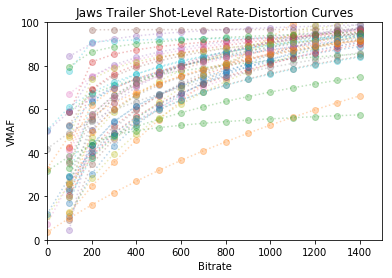

In [0]:
d = df.select("resolution", "log_params").toPandas()
log_fit = lambda x, a, b, c: a * np.log(x + b) + c
bitrates = np.arange(0, 1500, 100)

for pms in d.log_params.values:
  vmafs = log_fit(bitrates, *pms).tolist()
  vmafs = [y for y in vmafs if y > 0]
  plt.plot(bitrates[-len(vmafs):], vmafs, ":o", alpha=0.3)
  
plt.title("Jaws Trailer Shot-Level Rate-Distortion Curves")
plt.axis([0, 1500, 0, 100])
plt.xlabel("Bitrate")
plt.ylabel("VMAF")
plt.show()

We see that rate-distortion curves vary considerably at the shot-level, even for a short movie trailer.

Our computation indicates optimal bitrate ranges for high-resolution encodings, but the job was demanding and we still need to probe at lower resolutions.

[Netflix researchers](https://arxiv.org/pdf/2103.07564.pdf) found that for high resolutions, the point of highest curvature often lies on the Pareto Frontier. 

Regressing these so-called [knee points](https://en.wikipedia.org/wiki/Knee_of_a_curve) may reduce the problem of constructing an optimal bitrate ladder so they applied
[Kneedle's algorithm](https://www.researchgate.net/publication/224249192_Finding_a_Kneedle_in_a_Haystack_Detecting_Knee_Points_in_System_Behavior) to the task.

Using the second derivative to approximate the curvature of our interpolants, knee points are near maximizers of a simple function:

$$   \frac{d^2}{{dx}^2} \left( a * \log(x + b) + c\right) = \frac{-a}{(x + b)^2}$$

In [0]:
@udf(returnType=T.FloatType())
def knee_point(params):
  return params[1]

df = df.orderBy("resolution").withColumn("knee_QPs", knee_point(F.col("log_params")))
display(df)

video,resolution,segment,bitrates,rd_curve,log_params,knee_QPs
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1034, end_fno=1123)","List(100, 300, 500, 800)","List(11.860266, 43.67301, 62.106222, 75.974556)","List(34.604397, 27.48412, -155.98683)",27.48412
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=743, end_fno=779)","List(100, 300, 500, 800)","List(13.72624, 30.116484, 59.933162, 77.763513)","List(128.6421, 923.5049, -879.3414)",923.5049
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=388, end_fno=469)","List(100, 300, 500, 800)","List(57.32325, 71.115603, 75.536362, 80.521659)","List(8.630235, -47.57589, 23.165148)",-47.57589
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1728, end_fno=1753)","List(100, 300, 500, 800)","List(24.509284, 53.002672, 66.997788, 78.856388)","List(26.391724, 1.5332143, -97.45124)",1.5332143
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=663, end_fno=685)","List(100, 300, 500, 800)","List(59.259348, 80.983049, 86.560646, 91.026659)","List(8.386536, -83.84251, 35.92427)",-83.84251
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1123, end_fno=1154)","List(100, 300, 500, 800)","List(52.006106, 75.338304, 82.611907, 87.896181)","List(10.746716, -74.66247, 17.26533)",-74.66247
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1416, end_fno=1438)","List(100, 300, 500, 800)","List(26.423766, 48.208655, 60.796594, 74.485079)","List(33.919754, 125.325485, -157.30515)",125.325485
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=685, end_fno=709)","List(100, 300, 500, 800)","List(24.061935, 64.950693, 77.927814, 86.141375)","List(18.006205, -77.654594, -31.88864)",-77.654594
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1669, end_fno=1713)","List(100, 300, 500, 800)","List(26.348733, 58.66907, 73.395815, 85.530803)","List(26.259045, -18.589113, -89.1969)",-18.589113
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1019, end_fno=1034)","List(100, 300, 500, 800)","List(77.316741, 91.620222, 92.354226, 92.354226)","List(0.79565895, -100.0, 87.37492)",-100.0


In the spirit of Neflix's CIL estimation method, we propose learning to regress knee points from sparsely sampled images.

We aim to trade an explosion of costly transcoding jobs for inference over a sparse set of images to more efficiently probe QP ranges lying on the PF.

In [0]:
@udf(returnType=SegmentType())
def image_sampler(segment):
  return Segment(np.random.randint(segment.start_fno, segment.end_fno), -1)
 
df = (df.withColumn("image", image_sampler(F.col("segment")))
        .withColumn("image", F.explode(video_to_images(F.col("video"), F.lit(""), F.col("image"), F.lit(1), F.lit(1)))))
display(df.select("video", "resolution", "segment", "image", "knee_QPs"))

video,resolution,segment,image,knee_QPs
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1034, end_fno=1123)",Image('1088.png'),46.685402
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=743, end_fno=779)",Image('743.png'),843.0492
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=388, end_fno=469)",Image('427.png'),-52.802055
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1728, end_fno=1753)",Image('1732.png'),6.0759745
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=663, end_fno=685)",Image('674.png'),-81.65569
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1123, end_fno=1154)",Image('1139.png'),-72.32339
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1416, end_fno=1438)",Image('1417.png'),104.11746
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=685, end_fno=709)",Image('687.png'),-76.766335
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1669, end_fno=1713)",Image('1670.png'),7.7745185
VideoStream(uri='/dbfs/mnt/vids/Jaws.mp4'),2560:1080,"Segment(start_fno=1019, end_fno=1034)",Image('1031.png'),-99.99999


Equipped with algorithmic techniques to generate labels and extract features, we train a model to regress VMAF from content features as an important reductive step to avoid more exhaustive probing in the sequel.